This is to generate illustrative example for figure 1

In [1]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import *
from scipy.interpolate import *
from cluster_functions import *


import pyhsmm
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, cov

import autoregressive.models as m
import autoregressive.distributions as d

from polyagamma import random_polyagamma
from pyhmc import hmc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gamma, digamma
from scipy.stats import norm, nbinom, multivariate_normal
from tqdm import tqdm
import heapq

import numpy.matlib
import time
from IPython import display

import warnings
warnings.filterwarnings("ignore")

/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [194]:
n = 10
nClus = 3
N = n*nClus
p = 2
T = 250

np.random.seed(0)
lab_neuron = np.repeat(np.arange(nClus), n)

dd = np.random.normal(size = (n*nClus,1))*0.1
C_true= np.random.normal(size = (nClus*n,p))

As = [block_diag(0.02*np.eye(p+1), 
                 0.95*np.eye(p+1), 
                 0.01*np.eye(p+1)),
      block_diag(0.95*random_rotation(p+1, theta= np.pi/20),
                 0.01*random_rotation(p+1, theta= np.pi/20),
                 .95*random_rotation(p+1, theta= np.pi/20))]


truemodel = m.ARHSMM(
        alpha=5.,init_state_concentration=5.,
        obs_distns=[d.AutoRegression(A=A,sigma=np.eye(nClus*(p+1))*1e-2) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=100,beta_0=2)
            for state in range(len(As))],
        )


X_all_tmp, lab_t_tmp = truemodel.generate(2*T, keep=True)
X_all = X_all_tmp[(T+1):,:].T
lab_t = lab_t_tmp[T:]

muX_all = []
for cc in range(nClus):
    muX_all.append(X_all[(cc*(p+1)):((cc+1)*(p+1)),:])
    
dynm = {}
dynm['As'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['bs'] = np.zeros((2,3*(p+1)))
dynm['Qs'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['states'] = np.zeros((T,), dtype = int)


# muX_b, C_b, delt_b.ravel(), dynamics_b

muX_all, _, _, _ = constraint(muX_all, C_true,dd.reshape((-1, 1)),dynm, lab_neuron)    
X_all = np.zeros_like(X_all)
for cc in range(nClus):
    X_all[(cc*(p+1)):((cc+1)*(p+1)),:] = muX_all[cc]

    
C_trans = np.zeros((n*nClus, (p+1)*nClus))
for cc in range(nClus):
    C_trans[(n*cc):(n*(cc+1)),(cc*(p+1)):((cc+1)*(p+1))] = np.column_stack((np.ones((n,1)), C_true[(n*cc):(n*(cc+1)),:]))    
    
Lam_true = np.exp(dd + C_trans @ X_all)
r_true = np.ones((n*nClus,1))*10
p_true = r_true/(r_true+Lam_true)
y = np.random.negative_binomial(r_true, p_true, size=None)

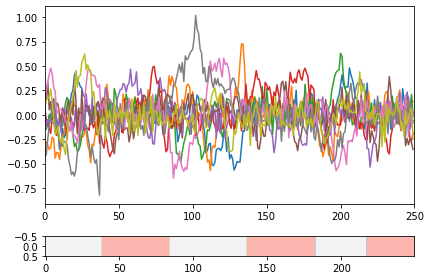

In [195]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

a0.plot(X_all .T)
a0.set_xlim([0, T])
a1.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')

f.tight_layout()

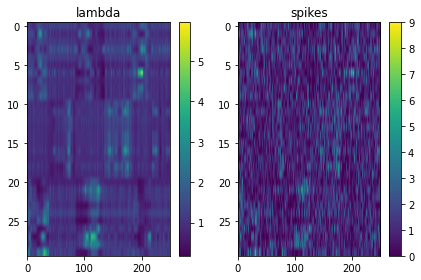

In [196]:
fig, ax = plt.subplots(1,2)

z1 = ax[0].imshow(Lam_true, aspect='auto')
ax[0].set_title('lambda')
plt.colorbar(z1, ax= ax[0])

z2 = ax[1].imshow(y, aspect='auto')
ax[1].set_title('spikes')
plt.colorbar(z2, ax= ax[1])

fig.tight_layout()

# obs.
## permute version

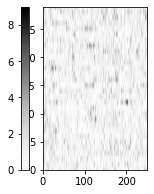

In [253]:
plt.rcParams['figure.figsize'] = [2.5, 3]
perm_idx = np.random.permutation(N)

fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(y[perm_idx,:], aspect='auto', cmap = 'Greys')
cb = plt.colorbar(axp,ax=[ax],location='left')
ax.set_ylim([0, N-1])
ax.set_xlim([0, T])

plt.savefig("unsorted_obs_colBar.svg")

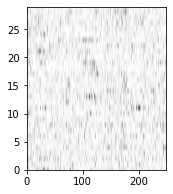

In [252]:
plt.rcParams['figure.figsize'] = [2.5, 3]
plt.imshow(y[perm_idx,:], aspect='auto', cmap = 'Greys')
# plt.colorbar()
plt.ylim([0, N-1])
plt.xlim([0, T])

plt.savefig("unsorted_obs.svg")

## sorted version

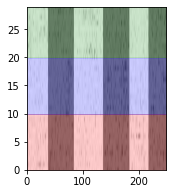

In [262]:
plt.rcParams['figure.figsize'] = [2.5, 3]
plt.imshow(y, aspect='auto', cmap = 'Greys')
# plt.colorbar()
plt.ylim([0, N-1])
plt.xlim([0, T])
col_str = ['red', 'blue', 'green']
for cc in range(nClus):
    plt.fill_between(np.arange(0,T), cc*n, min(N-1, (cc+1)*n-0.1), color=col_str[cc], alpha=0.2)
plt.imshow(np.matlib.repmat(lab_t, N, 1), aspect="auto", cmap='gray', alpha = 0.5)

plt.savefig("sorted_obs.svg")

# latnet trajectoreis

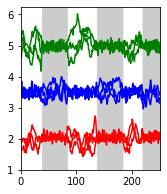

In [243]:
plt.rcParams['figure.figsize'] = [2.5, 3]
for nn in range(nClus):
    plt.plot(2+ nn*1.5 + muX_all[nn].T, color=col_str[nn])
plt.imshow(np.matlib.repmat(lab_t, 10, 1), aspect="auto", cmap='gray', alpha = 0.2)
plt.ylim([1, 6.25])
plt.xlim([0, T])

plt.savefig("latent.svg")